In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
cwd =  os.getcwd()
print('Current working directory:', cwd)

data_dir = os.path.join(cwd, 'data_2023')

# Check if the directory exists
if os.path.isdir(data_dir):
    print('Data directory found at', data_dir)
else:
    print('Error: data directory not found')

print(os.listdir(data_dir))

Current working directory: /Users/harrybingham/Documents/GitHub/anxiety-rl-analysis
Data directory found at /Users/harrybingham/Documents/GitHub/anxiety-rl-analysis/data_2023
['inst_outcomes.csv', 'stai_scores.csv', 'inst_choices.csv', 'README.md']


In [4]:
# Load the STAI-Y2 scores data
stai_df = pd.read_csv(os.path.join(data_dir, 'stai_scores.csv'), header=None)

# Load the choices data
choices_df = pd.read_csv(os.path.join(data_dir, 'inst_choices.csv'), header=None)

# Load the outcomes data
outcomes_df = pd.read_csv(os.path.join(data_dir, 'inst_outcomes.csv'), header=None)

""" All data has been loaded correctly. """

' All data has been loaded correctly. '

In [5]:
print(stai_df.head())

    0
0  65
1  46
2  61
3  41
4  51


In [6]:
num_trials = 160
# Remove header

In [7]:
mean_stai = stai_df.mean()
print('Mean STAI score:', mean_stai)

median_stai = stai_df.median()
print('Median STAI score:', median_stai)

std_stai = stai_df.std()
print('Standard deviation of STAI score:', std_stai)

Mean STAI score: 0    42.72
dtype: float64
Median STAI score: 0    40.0
dtype: float64
Standard deviation of STAI score: 0    14.880531
dtype: float64


In [8]:
stai_cutoff = 43
num_healthy_controls = (len(stai_df[stai_df.iloc[:, 0] <= stai_cutoff]) + 1)
num_participants = (stai_df.shape[0] + 1)
print("Number of participants", num_participants)
print('Number of healthy controls:', num_healthy_controls)
print('Number of anxious participants:', num_participants - num_healthy_controls)

""" The number of participants expected to fit in each group based on self-resport is 25/25 (control/anxious). However, given a STAI cutoff of 43, the number of participants in each group is 29/21 (controls/anxious). Hereafter, we will assume the self-reported data is correct. """

Number of participants 51
Number of healthy controls: 30
Number of anxious participants: 21


' The number of participants expected to fit in each group based on self-resport is 25/25 (control/anxious). However, given a STAI cutoff of 43, the number of participants in each group is 29/21 (controls/anxious). Hereafter, we will assume the self-reported data is correct. '

In [9]:
""" 
Compute the number of times each participant choose option A. Report the average of this number (or
percentage) across all subjects. What is the expected number of aversive sounds experienced by participants
who respond randomly throughout the experiment? Did our participants perform the task well? 
"""

# Compute the number of times each participant chose option A
num_A = []
for index, row in choices_df.iterrows():
    num_A.append(row.tolist().count(1))

print("Number of times each participant chose option A", num_A)

# Compute the average number of times each participant chose option A
avg_num_A = np.mean(num_A)
print('Average number of times each participant chose option A:', avg_num_A)

""" 
The expected number of aversive sounds experienced by participants given random choices is 80. The average number of times each participant chose option A is 34.1 . 
This suggests that our participants performed the task well. 21.3% of the time, they chose option A
"""
None

Number of times each participant chose option A [52, 46, 32, 58, 37, 26, 28, 50, 38, 51, 53, 30, 31, 41, 36, 33, 41, 41, 28, 37, 53, 33, 40, 67, 31, 45, 29, 6, 25, 7, 12, 29, 21, 29, 16, 36, 39, 27, 41, 25, 39, 28, 29, 36, 45, 24, 16, 53, 31, 22]
Average number of times each participant chose option A: 34.46


In [10]:
def update_V(V_i_t, o_t, alpha):
    """
    Update the value of V_i at time t+1 given its previous value at time t and the observed outcome o_t.
    
    Args:
    V_i_t (float): The previous value of V_i at time t.
    o_t (float): The observed outcome at time t.
    alpha (float): The learning rate.
    
    Returns:
    float: The updated value of V_i at time t+1.
    """
    V_i_t_plus_1 = V_i_t + alpha * (o_t - V_i_t)
    return V_i_t_plus_1

def p(action, V_A, V_B, beta):
    # Compute the exponentiated values for each option
    exp_A = np.exp(-beta * V_A)
    exp_B = np.exp(-beta * V_B)

    # Compute the probability of selecting option A
    probability = exp_A / (exp_A + exp_B)

    # Return the probability of selecting the specified action
    if action == 'A':
        return probability
    else:
        return 1 - probability



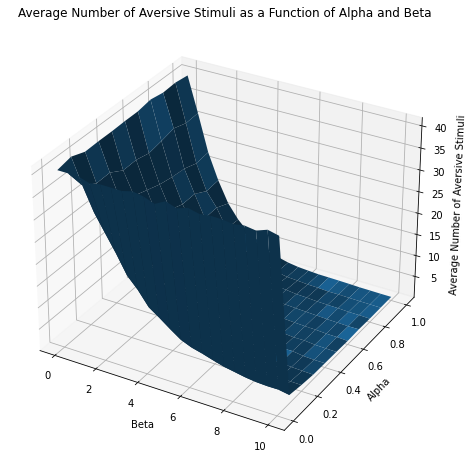

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def simulate_aversive_stimuli(alpha, beta, V0, num_trials, num_simulations):
    aversive_stimuli_count = 0

    for _ in range(num_simulations):
        V_A = V0
        V_B = V0

        for t in range(1, num_trials + 1):
            # Calculate the probability of choosing action A
            prob_A = p('A', V_A, V_B, beta)

            # Randomly choose action A or B based on the probabilities
            action = np.random.choice(['A', 'B'], p=[prob_A, 1 - prob_A])

            # Determine the outcome based on the current trial and chosen action
            o_t = 1 if (t - 1) % 40 < 20 and action == 'A' else 0

            # Update the values of V_A and V_B based on the chosen action and outcome
            if action == 'A':
                V_A = update_V(V_A, o_t, alpha)
            else:
                V_B = update_V(V_B, o_t, alpha)

            aversive_stimuli_count += o_t

    avg_aversive_stimuli = aversive_stimuli_count / num_simulations
    return avg_aversive_stimuli

# Parameter ranges
alpha_values = np.linspace(0, 1, 11)
beta_values = np.linspace(0, 10, 21)

# Simulations
V0 = 0.5
num_trials = 160
num_simulations = 100

# Compute the average number of aversive stimuli for each combination of alpha and beta
results = np.zeros((len(alpha_values), len(beta_values)))

for i, alpha in enumerate(alpha_values):
    for j, beta in enumerate(beta_values):
        results[i, j] = simulate_aversive_stimuli(alpha, beta, V0, num_trials, num_simulations)

# 3D plot of the results
X, Y = np.meshgrid(beta_values, alpha_values)
Z = results

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

ax.set_xlabel('Beta')
ax.set_ylabel('Alpha')
ax.set_zlabel('Average Number of Aversive Stimuli')
ax.set_title('Average Number of Aversive Stimuli as a Function of Alpha and Beta')

plt.show()

In [12]:
import numpy as np

def negative_log_likelihood(choices, outcomes, V0, alpha, beta):
    num_trials = len(choices)
    V_A = V0
    V_B = V0
    NLL = 0

    for t in range(num_trials):
        choice = choices[t]
        outcome = outcomes[t]

        # Calculate the probability of the chosen action given the current values of V_A and V_B
        if choice == 1:
            prob_choice = p('A', V_A, V_B, beta)
        else:
            prob_choice = p('B', V_A, V_B, beta)

        # Update the negative log likelihood
        NLL -= np.log(prob_choice)

        # Update the values of V_A and V_B based on the chosen action and observed outcome
        if choice == 1:
            V_A = update_V(V_A, outcome, alpha)
        else:
            V_B = update_V(V_B, outcome, alpha)

    return NLL

# Get the data for the 4th and 5th and 9th participant
choices_4th = choices_df.iloc[3].tolist()
outcomes_4th = outcomes_df.iloc[3].tolist()
choices_5th = choices_df.iloc[4].tolist()
outcomes_5th = outcomes_df.iloc[4].tolist()
choices_9th = choices_df.iloc[8].tolist()
outcomes_9th = outcomes_df.iloc[8].tolist()

# Set the parameter values
V0 = 0.5
alpha = 0.4
beta = 7

# Calculate the NLL for the 4th and 5th and 9th participant
NLL_4th = negative_log_likelihood(choices_4th, outcomes_4th, V0, alpha, beta)
NLL_5th = negative_log_likelihood(choices_5th, outcomes_5th, V0, alpha, beta)
NNL_9th = negative_log_likelihood(choices_9th, outcomes_9th, V0, alpha, beta)

print("NLL for the 4th participant:", NLL_4th)
print("NLL for the 5th participant:", NLL_5th)
print("NLL for the 9th participant:", NNL_9th)


NLL for the 4th participant: 101.60502062243488
NLL for the 5th participant: 52.68861467295331
NLL for the 9th participant: 60.877333438783324


Mean alpha: 0.4758865798481678
Variance of alpha: 0.028823177110009483
Mean beta: 5.165364859938008
Variance of beta: 2.7646122988261386


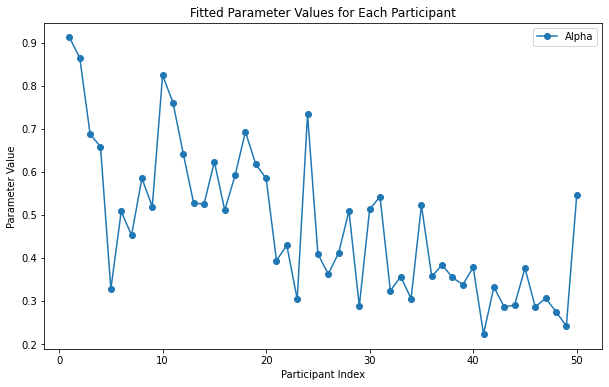

Correlation between alpha and beta (all participants): -0.2369656492300811
Correlation between alpha and beta (high anxious): -0.4674526103015522
Correlation between alpha and beta (low anxious): 0.4090063852196178


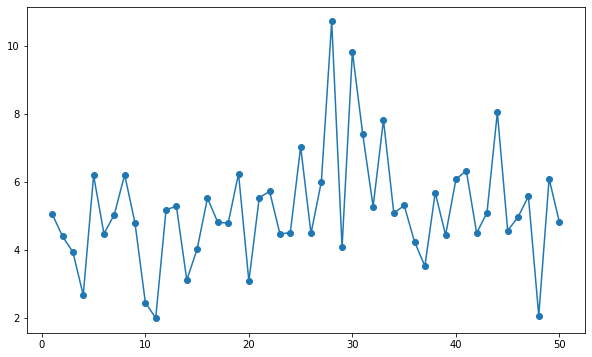

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

def minimize_nll_for_individual(choices, outcomes, V0, initial_params):
    res = minimize(lambda x: negative_log_likelihood(choices, outcomes, V0, x[0], x[1]),
                   initial_params, method='Nelder-Mead')
    return res.x

# Define the initial parameter values
initial_params = [0.4, 7]
V0 = 0.5

# Fit the parameters for each participant
num_participants = len(choices_df)
fitted_params = np.zeros((num_participants, 2))

for i in range(num_participants):
    choices = choices_df.iloc[i].tolist()
    outcomes = outcomes_df.iloc[i].tolist()
    fitted_params[i] = minimize_nll_for_individual(choices, outcomes, V0, initial_params)

# Calculate mean and variance of fitted parameter values
mean_alpha = np.mean(fitted_params[:, 0])
var_alpha = np.var(fitted_params[:, 0])
mean_beta = np.mean(fitted_params[:, 1])
var_beta = np.var(fitted_params[:, 1])

print("Mean alpha:", mean_alpha)
print("Variance of alpha:", var_alpha)
print("Mean beta:", mean_beta)
print("Variance of beta:", var_beta)

# Plot the parameter values against participant index
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_participants + 1), fitted_params[:, 0], label='Alpha', marker='o')
plt.xlabel('Participant Index')
plt.ylabel('Parameter Value')
plt.title('Fitted Parameter Values for Each Participant')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, num_participants + 1), fitted_params[:, 1], label='Beta', marker='o')
plt.show

# Calculate Pearson's correlation coefficients
correlation_all = np.corrcoef(fitted_params[:, 0], fitted_params[:, 1])[0, 1]
correlation_high_anxious = np.corrcoef(fitted_params[:25, 0], fitted_params[:25, 1])[0, 1]
correlation_low_anxious = np.corrcoef(fitted_params[25:, 0], fitted_params[25:, 1])[0, 1]

print("Correlation between alpha and beta (all participants):", correlation_all)
print("Correlation between alpha and beta (high anxious):", correlation_high_anxious)
print("Correlation between alpha and beta (low anxious):", correlation_low_anxious)


In [14]:
from scipy.stats import ttest_ind

# Separate the high and low anxious groups
high_anxious_params = fitted_params[:25]
low_anxious_params = fitted_params[25:]

# Perform two-sample t-tests for alpha and beta
t_alpha, p_alpha = ttest_ind(high_anxious_params[:, 0], low_anxious_params[:, 0])
t_beta, p_beta = ttest_ind(high_anxious_params[:, 1], low_anxious_params[:, 1])

# Calculate degrees of freedom
df = len(high_anxious_params) + len(low_anxious_params) - 2

print("Alpha:")
print("  t statistic:", t_alpha)
print("  Degrees of freedom:", df)
print("  p value:", p_alpha)

print("Beta:")
print("  t statistic:", t_beta)
print("  Degrees of freedom:", df)
print("  p value:", p_beta)


Alpha:
  t statistic: 6.042165319443778
  Degrees of freedom: 48
  p value: 2.1617585738290225e-07
Beta:
  t statistic: -2.2309569492149133
  Degrees of freedom: 48
  p value: 0.030391370915077456


In [18]:
from scipy.optimize import minimize

def simulate_data(alpha, beta, V0, num_trials):
    V_A = V0
    V_B = V0
    choices = []
    outcomes = []

    for t in range(num_trials):
        # Calculate the probability of choosing A
        prob_A = p('A', V_A, V_B, beta)
        choice = np.random.choice([1, 2], p=[prob_A, 1 - prob_A])
        choices.append(choice)

        # Generate the outcome for the chosen action (e.g., 0 for neutral, 1 for aversive)
        # You can modify the probabilities based on the experimental design
        outcome = np.random.choice([0, 1], p=[0.8 if choice == 1 else 0.2, 0.2 if choice == 1 else 0.8])
        outcomes.append(outcome)

        # Update the values of V_A and V_B based on the chosen action and observed outcome
        if choice == 1:
            V_A = update_V(V_A, outcome, alpha)
        else:
            V_B = update_V(V_B, outcome, alpha)

    return choices, outcomes


def fit_parameters(choices, outcomes, V0):
    # Define a function to minimize, which takes a parameter vector (alpha, beta) as input
    def to_minimize(params):
        alpha, beta = params
        return negative_log_likelihood(choices, outcomes, V0, alpha, beta)

    # Set the initial parameter values
    init_params = np.array([0.4, 7])

    # Perform the optimization using the Nelder-Mead algorithm
    result = minimize(to_minimize, init_params, method='Nelder-Mead')

    # Extract the fitted parameter values
    fitted_alpha, fitted_beta = result.x

    return fitted_alpha, fitted_beta


In [20]:
from scipy.stats import multivariate_normal, pearsonr

# Choose sensible mean values for alpha and beta
mean_alpha = 0.47
mean_beta = 5.16

# Define the multivariate normal distribution
mean = [mean_alpha, mean_beta]
cov = [[0.01, 0], [0, 0.5]]
mvn = multivariate_normal(mean, cov)

# Sample 50 sets of parameter values
sampled_params = mvn.rvs(size=50)

# Remove nonsensical values (e.g., negative alpha or beta)
valid_sampled_params = []
for params in sampled_params:
    if params[0] > 0 and params[1] > 0:
        valid_sampled_params.append(params)
valid_sampled_params = np.array(valid_sampled_params)

# Perform parameter recovery 5 times
num_trials = 160
correlations = []

for i in range(5):
    recovered_params_list = []
    for params in valid_sampled_params:
        # Simulate data with the true parameters
        choices, outcomes = simulate_data(params[0], params[1], V0, num_trials)

        # Fit new parameters to the simulated data
        recovered_params = fit_parameters(choices, outcomes, V0)
        recovered_params_list.append(recovered_params)
    
    recovered_params_array = np.array(recovered_params_list)

    # Calculate Pearson's correlation for alpha and beta
    r_alpha, _ = pearsonr(valid_sampled_params[:, 0], recovered_params_array[:, 0])
    r_beta, _ = pearsonr(valid_sampled_params[:, 1], recovered_params_array[:, 1])
    correlations.append((r_alpha, r_beta))

    print(f"Iteration {i + 1}:")
    print(f"  Pearson's correlation for alpha: {r_alpha}")
    print(f"  Pearson's correlation for beta: {r_beta}")


Iteration 1:
  Pearson's correlation for alpha: 0.6882820512946316
  Pearson's correlation for beta: 0.26848342470149705
Iteration 2:
  Pearson's correlation for alpha: 0.41804212083356995
  Pearson's correlation for beta: 0.23944849710287425
Iteration 3:
  Pearson's correlation for alpha: 0.46467476039719136
  Pearson's correlation for beta: 0.281341064458488
Iteration 4:
  Pearson's correlation for alpha: 0.6802198782592411
  Pearson's correlation for beta: 0.5189811333838951
Iteration 5:
  Pearson's correlation for alpha: 0.549483391612476
  Pearson's correlation for beta: 0.015466523911584292
